In [1]:
import os
import time
import random

import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import timm
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

/data/ephemeral/home/cv01/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'datasets_fin/'

# model config
model_name = 'resnet34' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 32
LR = 1e-3
EPOCHS = 1
BATCH_SIZE = 32
num_workers = 0

# 1. Data Load

In [4]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

# 2. Data Transform

In [5]:
transform_0 = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
transform_1 = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Blur(blur_limit=[4,4], always_apply=True),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
transform_2 = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.GaussNoise(var_limit=(300, 300), p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
transform_3 = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.ISONoise(intensity=(1.5, 1.5), p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [6]:
datasets0 = ImageDataset("data/train.csv","data/train/",transform_0)
datasets1 = ImageDataset("data/train.csv","data/train/",transform_1)
datasets2 = ImageDataset("data/train.csv","data/train/",transform_2)
datasets3 = ImageDataset("data/train.csv","data/train/",transform_3)

In [7]:
datasets1[0][0].shape

torch.Size([3, 32, 32])

In [8]:
datasets1[0][1]

16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


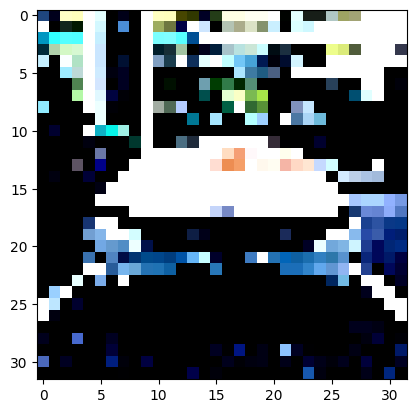

In [9]:
plt.imshow(datasets0[0][0].permute(1,2,0))

# 4. Training

In [10]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device, loss_logs=False):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []
    lst = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        if loss_logs:
            lst.append(loss.item())

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret, lst

# 3. Model

In [ ]:
loss_logs = []
for datasets in [datasets0,datasets1,datasets2,datasets3]:
    # DataLoader 정의
    trn_loader = DataLoader(
        datasets,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )

    # load model
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=17
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=LR)

    for epoch in range(EPOCHS):
        ret, lst = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device, loss_logs=True)
        ret['epoch'] = epoch

        loss_logs.append(lst)

        log = ""
        for k, v in ret.items():
            log += f"{k}: {v:.4f}\n"
            print(log)

Loss: 2.2833: 100%|██████████| 50/50 [00:04<00:00, 12.08it/s]


train_loss: 2.5066

train_loss: 2.5066
train_acc: 0.2497

train_loss: 2.5066
train_acc: 0.2497
train_f1: 0.2207

train_loss: 2.5066
train_acc: 0.2497
train_f1: 0.2207
epoch: 0.0000



Loss: 2.1223: 100%|██████████| 50/50 [00:03<00:00, 14.90it/s]


train_loss: 2.4802

train_loss: 2.4802
train_acc: 0.2490

train_loss: 2.4802
train_acc: 0.2490
train_f1: 0.2163

train_loss: 2.4802
train_acc: 0.2490
train_f1: 0.2163
epoch: 0.0000



Loss: 2.7931: 100%|██████████| 50/50 [00:03<00:00, 12.64it/s]


train_loss: 2.5646

train_loss: 2.5646
train_acc: 0.2306

train_loss: 2.5646
train_acc: 0.2306
train_f1: 0.1975

train_loss: 2.5646
train_acc: 0.2306
train_f1: 0.1975
epoch: 0.0000



Loss: 2.6048: 100%|██████████| 50/50 [00:04<00:00, 12.41it/s]

train_loss: 2.5876

train_loss: 2.5876
train_acc: 0.2108

train_loss: 2.5876
train_acc: 0.2108
train_f1: 0.1822

train_loss: 2.5876
train_acc: 0.2108
train_f1: 0.1822
epoch: 0.0000



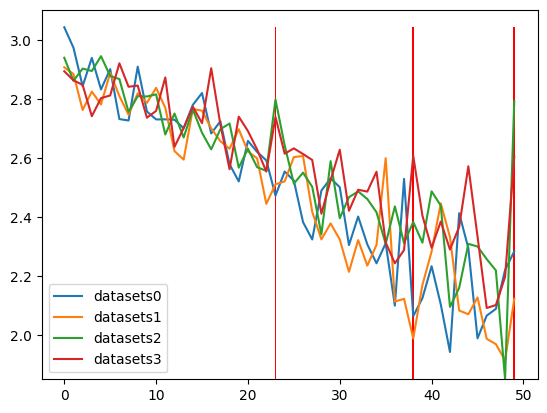

In [76]:
lst = list(range(len(loss_logs[0])))
y_min = min(list(map(min,loss_logs)))
y_max = max(list(map(max,loss_logs)))
plt.plot(lst,loss_logs[0],lst,loss_logs[1],lst,loss_logs[2],lst,loss_logs[3])
plt.bar(x=23,bottom=y_min,height=(y_max-y_min),width=0.2,color="r")
plt.bar(x=38,bottom=y_min,height=(y_max-y_min),width=0.2,color="r")
plt.bar(x=49,bottom=y_min,height=(y_max-y_min),width=0.2,color="r")
plt.legend(["datasets0","datasets1","datasets2","datasets3",])